In [3]:
import deepinv as dinv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch

from PMCPnP import PMCPnP
from utils import get_physics, get_image, get_model

%load_ext autoreload
%autoreload 2

In [4]:
EXPERIMENT_DIRECTORY = Path().cwd() / "experiments"
DATA_DIRECTORY = Path().cwd() / "data"
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


Selected GPU 0 with 24128 MB free memory 


In [5]:
# possible images are "face1", "face2", "face3", "bedroom", "butterfly"
img_size = 256
name = "face1"
image = get_image(DATA_DIRECTORY, name=name, img_size=img_size, device=device)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/deepinv/physics/blur.py:264: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  y[i, j, :, :] = F.conv2d(


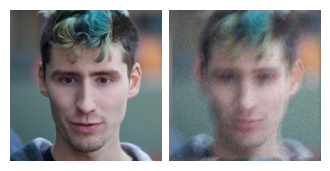

In [6]:
# possible physics are "denoising", "compressed_sensing", "inpainting", "downsampling" and "blur"
transformation_name = "blur"
SIGMA = 0.05
physics = get_physics(transformation_name, img_size, SIGMA, device=device, factor=10)


print(image.shape, physics(image).shape)
dinv.utils.plotting.plot([image, physics(image)])

Best hyperparameters (range):
- PnP: max_iter=200, stepsize=0.1, lambda=0.01
- RED: max_iter=200, stepsize=0.1, lambda=0.01
- DPS: max_iter=1000
- PnP-ULA: max_iter=, stepsize=
- PMCPnP: max_iter=, stepsize=1e-3

In [84]:
model_name = 'RED'
max_iter = 500
stepsize = 0.05
lambd = 0.01

denoiser = dinv.models.DnCNN(pretrained="download").to(device)#DiffUNet(large_model=False).to(device)
likelihood = dinv.optim.L2(sigma=SIGMA)

model = get_model(model_name,
                  denoiser, 
                  likelihood, 
                  max_iter=max_iter,
                  stepsize=stepsize,
                  lambd=lambd,
                  sigma=SIGMA,
                  device=device)

In [85]:
x = image.clone()
y = physics(x)

out, metrics = model(y, physics, x_gt=x, compute_metrics=True)
print(out.min(), out.max())

tensor(-0.0081, device='cuda:0') tensor(0.8912, device='cuda:0')


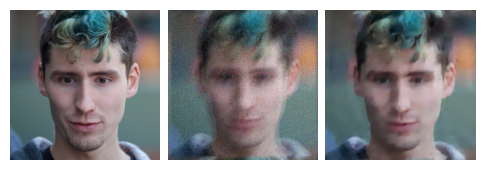

In [88]:
dinv.utils.plotting.plot([x, y, out], rescale_mode='clip')

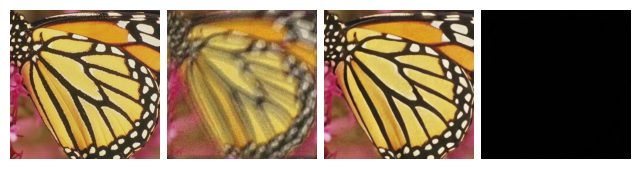

In [56]:
import pickle

pickle.dump(metrics, open(EXPERIMENT_DIRECTORY / f"{model_name}_metrics.pkl", "wb"))